In [1]:
from ephysvibe.structures.population_data import PopulationData
from ephysvibe.structures.neuron_data import NeuronData
from ephysvibe.structures.results import Results
from ephysvibe.stats import smetrics
# from preproc_tools import get_fr_by_sample
import numpy as np
#import compute_population_distance
from joblib import Parallel, delayed
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from ephysvibe.stats import smetrics

In [2]:
from scipy.spatial.distance import pdist
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity

In [3]:
x = np.array([[2, 0, 2], [2, 2, 3]])
x.shape

(2, 3)

In [142]:
u=np.array([1,0])
v=np.array([0,1])
print(x)
print(pdist(x,metric='cosine'))

[[2 0 2]
 [2 2 3]]
[0.14250707]


In [144]:
np.pi/2

1.5707963267948966

In [145]:
arccos(u.dot(v)/(norm(u)*norm(v)))*180/np.pi

90.0

In [5]:
distance.cosine(x[0],x[1])

0.1425070742874559

In [39]:
A = np.array([[1, 1]])
B = np.array([[1, 0]])

AttributeError: 'list' object has no attribute 'dot'

In [40]:
cosine_similarity(A)

array([[1.]])

In [41]:
(((1-cosine_similarity(A))/2)*np.pi)*360/(2*np.pi)

array([[1.99840144e-14]])

In [43]:
pdist(A,metric='euclidean')

array([], dtype=float64)

### Start preprocessing

In [148]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [149]:
1050+400+550

2000

In [150]:
import pandas as pd
import preproc_tools
seed=1997

In [7]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    rng = np.random.default_rng(seed)
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        preproc_tools.get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]

    print("start iterations")
    distance_data = []
    for _ in tqdm(range(1000)):
        dist = get_distance(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_dist_n_nn = []
    all_dist_fake_n_nn = []
    for asc in distance_data:
        all_dist_n_nn.append(asc["dist_n_nn"])
        all_dist_fake_n_nn.append(asc["dist_fake_n_nn"])
    all_dist_n_nn = np.array(all_dist_n_nn, dtype=np.float32)
    all_dist_fake_n_nn = np.array(all_dist_fake_n_nn, dtype=np.float32)
    res["dist_n_nn"] = all_dist_n_nn
    res["dist_fake_n_nn"] = all_dist_fake_n_nn
    res["n_neurons"] = asc["n_neurons"]

    res = Results("population_distance.py", input, distance=res)
    return res

In [8]:

def scrum_neutralsize_samepool(data, ntr, rng):

    nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [9]:
def get_distance(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []
    if metric == 'cosine':
        model = PCA(n_components=select_n_neu).fit(reshape_pc.reshape(select_n_neu,-1).T)
        C = model.components_
        reshape_pc = reshape_pc - C.reshape(-1,1,1)


    for i in range(reshape_pc.shape[-1]):

        dist_n_nn.append(
            pdist(np.array((reshape_pc[:, 0, i], reshape_pc[:, 1, i])), metric=metric)
        )
        dist_fake_n_nn.append(
            pdist(np.array((fr_groups[:, 0, i], fr_groups[:, 1, i])), metric=metric)
        )

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


Compute distances


100%|██████████| 530/530 [00:08<00:00, 63.13it/s]


start iterations


  0%|          | 0/1000 [00:00<?, ?it/s]

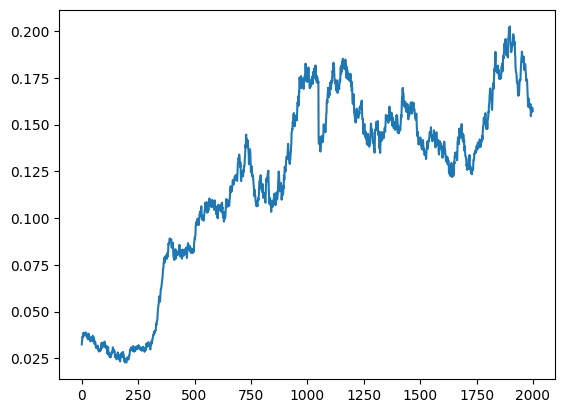

  0%|          | 0/1000 [07:02<?, ?it/s]


ValueError: operands could not be broadcast together with shapes (100,2,2000) (10000,1,1) 

In [11]:
res = compute_distance(**preprocessing, **paths)

In [30]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p

In [22]:
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

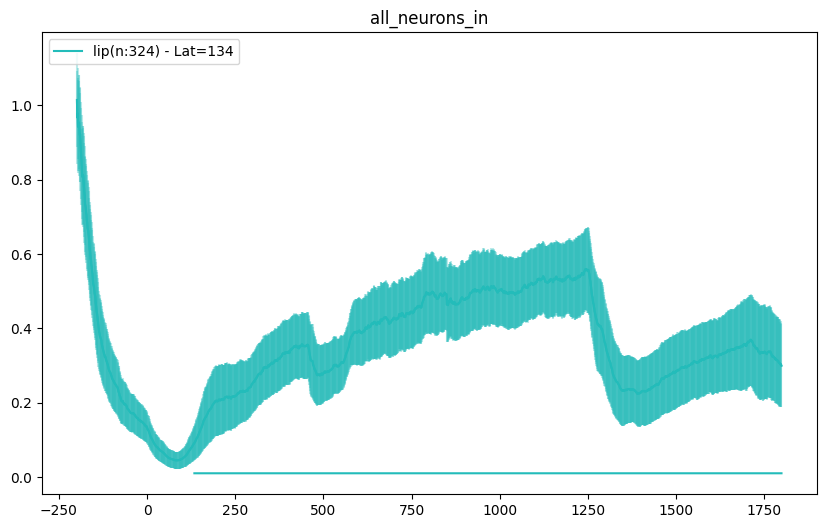

In [24]:
_=plt.figure(figsize=(10,6))
for ia,area in enumerate(['lip']):
    d=res.distance['dist_n_nn']
    fd=res.distance['dist_fake_n_nn']

    p = perm_test(d,fd)
    p = np.where(p>0.95,True,np.nan)
    latency,_=smetrics.find_latency(
        p_value=1-p, win=75, step= 1, p_treshold= 0.05
        )   
    p[:latency]=np.nan
    latency=latency-200

    _=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
    plt.errorbar(np.arange(len(p))-200,np.mean(d,axis=0),yerr=np.std(d,axis=0),color=color[area],alpha=0.3)
    _=plt.plot(np.arange(len(p))-200,(p/100)-(ia/10)+0,color=color[area])

plt.legend(loc='upper left')
_=plt.title('all_neurons_in')

### Test velocity

In [3]:
from scipy.signal.windows import gaussian
def define_kernel(w_size, w_std, fs):
    kernel = gaussian(M=w_size * fs, std=w_std * fs)
    kernel = kernel / sum(kernel)  # area of the kernel must be one
    return kernel
def convolve_signal(
    arr: np.ndarray,
    fs: int = 1000,
    w_size: float = 0.1,
    w_std: float = 0.015,
    axis: int = 1,
):
    # define kernel for convolution
    kernel = define_kernel(w_size, w_std, fs=fs)
    conv = np.apply_along_axis(
        lambda m: np.convolve(m, kernel, mode="same"), axis=axis, arr=arr
    )
    return conv * fs

In [4]:
from ephysvibe.trials import align_trials, select_trials
def select_trials_by_percentile(x: np.ndarray, mask: np.ndarray = None):
    ntr = x.shape[0]
    if mask is None:
        mask = np.full(ntr, True)

    mntr = x[mask].shape[0]

    if mntr < 2:
        return np.full(ntr, True)
    mean_trs = np.mean(x, axis=1)

    q25, q75 = np.percentile(mean_trs[mask], [25, 75])
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr
    lower_limit = q25 - 1.5 * iqr

    q1mask = mean_trs > lower_limit
    q2mask = mean_trs < upper_limit

    qmask = np.logical_and(q1mask, q2mask)
    return qmask


def check_trials(x, cerotr, percentile):
    masknocero = np.full(x.shape[0], True)
    maskper = np.full(x.shape[0], True)
    if cerotr:
        masknocero = np.sum(x, axis=1) != 0
    if percentile:
        maskper = select_trials_by_percentile(x, masknocero)
    mask = np.logical_and(masknocero, maskper)
    if np.sum(mask) < 5:
        mask = np.full(x.shape[0], True)
    return mask

def get_fr_by_sample(
    neu,
    time_before_son: str,
    time_before_t1on: str,
    sp_son: str,
    sp_t1on: str,
    mask_son: str,
    start_sample: int,
    end_sample: int,
    start_test: int,
    end_test: int,
    n_test,
    min_trials,
    min_neu=False,
    nonmatch=True,
    avgwin=50,
    n_sp_sec=5,
    norm=False,
    zscore=False,
    include_nid=None,
    cerotr=False,
    percentile=False,
):
    if include_nid is not None:
        nid = neu.get_neuron_id()
        if not (nid in include_nid):
            return None

    idx_start_sample = int((getattr(neu, time_before_son) + start_sample))
    idx_end_sample = int((getattr(neu, time_before_son) + end_sample))
    idx_start_test = int((getattr(neu, time_before_t1on) + start_test))
    idx_end_test = int((getattr(neu, time_before_t1on) + end_test))
    sampleon = getattr(neu, sp_son)
    t1on = getattr(neu, sp_t1on)
    mask_son = getattr(neu, mask_son)

    # Select trials aligned to sample onset

    sample_id = neu.sample_id[mask_son]

    # Build masks to select trials with match in the n_test
    mask_match = np.where(
        neu.test_stimuli[mask_son, n_test - 1] == neu.sample_id[mask_son],
        True,
        False,
    )
    mask_neu = neu.sample_id[mask_son] == 0
    # Build masks to select trials with the selected number of test presentations
    max_test = neu.test_stimuli[mask_son].shape[1]
    mask_ntest = (max_test - np.sum(np.isnan(neu.test_stimuli[mask_son]), axis=1)) > (
        n_test - 1
    )

    if nonmatch:  # include neutral and trials without a match before n_ntest (included)
        mask_match_neu = np.logical_or(mask_ntest, mask_neu)
    else:  # include neutral and trials with a match in the n_test
        mask_match_neu = np.logical_or(mask_match, mask_neu)
    if np.sum(mask_match_neu) < 20:
        return None

    # Average fr across time
    avg_sample_on = convolve_signal(
        sampleon[mask_match_neu],fs = 1000,w_size=0.1,w_std=0.015,axis=-1
    )[:, idx_start_sample:idx_end_sample]
    avg_test1_on = convolve_signal(t1on[mask_match_neu],fs = 1000,w_size=0.1,w_std=0.015,axis=-1)[
        :, idx_start_test:idx_end_test
    ]
    # Concatenate sample and test aligned data
    sp = np.concatenate((avg_sample_on, avg_test1_on), axis=1)
    # Check fr
    ms_fr = np.nanmean(sp) * 1000 > n_sp_sec
    if not ms_fr:
        return None
    # Check number of trials
    sample_id = neu.sample_id[mask_son][mask_match_neu]
    samples = [0, 11, 15, 55, 51]
    if min_neu:
        sample_fr = sp[np.where(sample_id == 0, True, False)]
        if sample_fr.shape[0] < min_trials:
            return None
    else:
        for s_id in samples:
            sample_fr = sp[np.where(sample_id == s_id, True, False)]
            if sample_fr.shape[0] < min_trials:
                return None
    if norm == True:
        sp = sp / np.max(sp)
    if zscore == True:
        sp_std = np.std(sp, ddof=1, axis=0)
        sp_std = np.where(sp_std == 0, 1, sp_std)
        sp = (sp - np.mean(sp, axis=0).reshape(1, -1)) / sp_std.reshape(1, -1)
    # Get trials grouped by sample
    fr_samples = select_trials.get_sp_by_sample(sp, sample_id, samples=samples)

    # check trials
    for isamp in fr_samples.keys():
        if ~np.all((np.isnan(fr_samples[isamp]))):
            masktr = check_trials(fr_samples[isamp], cerotr, percentile)
            fr_samples[isamp] = fr_samples[isamp][masktr]
            if fr_samples[isamp].shape[0] < min_trials:
                return None

    if fr_samples is None:
        return None

    return fr_samples


In [5]:
def scrum_neutralsize_samepool(data, ntr, rng):

    nn = np.concatenate((data["11"], data["15"], data["51"], data["55"]), axis=0)
    size_nn = nn.shape[0]

    idx_tr = rng.choice(size_nn, size=ntr, replace=False)
    nn_trs = nn[idx_tr]

    idx_tr = rng.choice(data["0"].shape[0], size=ntr, replace=False)
    neutral_trs = data["0"][idx_tr]

    meanfr0 = np.mean(neutral_trs, axis=0)
    meanfr11 = np.mean(nn_trs, axis=0)
    meanfr15 = np.mean(nn_trs, axis=0)
    meanfr51 = np.mean(nn_trs, axis=0)
    meanfr55 = np.mean(nn_trs, axis=0)

    all_s = np.concatenate((neutral_trs, nn_trs), axis=0)

    idx_tr = rng.choice(len(all_s), size=ntr * 2, replace=False)
    g1 = np.mean(all_s[idx_tr[:ntr]], axis=0)
    g2 = np.mean(all_s[idx_tr[ntr:]], axis=0)

    return meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2

In [6]:
def get_distance(data, rng, min_trials, metric, select_n_neu=100):

    g1mean, g2mean = [], []
    s0mean, s11mean, s15mean, s51mean, s55mean = [], [], [], [], []

    for idata in data:
        meanfr0, meanfr11, meanfr15, meanfr51, meanfr55, g1, g2 = (
            scrum_neutralsize_samepool(idata, min_trials, rng)
        )

        s0mean.append(meanfr0)
        s11mean.append(meanfr11)
        s15mean.append(meanfr15)
        s51mean.append(meanfr51)
        s55mean.append(meanfr55)
        g1mean.append(g1)
        g2mean.append(g2)

    neufr = {
        "0mean": s0mean,
        "11mean": s11mean,
        "15mean": s15mean,
        "51mean": s51mean,
        "55mean": s55mean,
        "g1mean": g1mean,
        "g2mean": g2mean,
    }

    fr_concat = np.concatenate(
        (
            neufr["0mean"],
            neufr["11mean"],
            neufr["15mean"],
            neufr["51mean"],
            neufr["55mean"],
        ),
        axis=1,
    )
    fr_group_concat = np.concatenate((neufr["g1mean"], neufr["g2mean"]), axis=1)

    n_neurons = fr_concat.shape[0]
    idx_neu = rng.choice(n_neurons, size=select_n_neu, replace=False)
    allsamp_fr = fr_concat[idx_neu]
    fr_group_concat = fr_group_concat[idx_neu]
    reshape_pc = allsamp_fr.reshape(select_n_neu, 5, -1)
    reshape_pc = np.concatenate(
        (reshape_pc[:, 0], np.mean(reshape_pc[:, 1:], axis=1)), axis=1
    ).reshape(select_n_neu, 2, -1)
    fr_groups = fr_group_concat.reshape(select_n_neu, 2, -1)
    dist_n_nn = []
    dist_fake_n_nn = []



    distv_n_nn,distv_fake_n_nn=[],[]
    dtime=1

    v0 = np.diff(reshape_pc[:,0,:],n=dtime,axis=1) / dtime
    v1 = np.diff(reshape_pc[:,1,:],n=dtime,axis=1) / dtime

    v0g = np.diff(fr_groups[:,0,:],n=dtime,axis=1) / dtime
    v1g = np.diff(fr_groups[:,1,:],n=dtime,axis=1) / dtime



    for i in range(reshape_pc.shape[-1]):

        pos0 = reshape_pc[:, 0, i]
        pos1 = reshape_pc[:, 1, i]

        pos0g = fr_groups[:, 0, i]
        pos1g = fr_groups[:, 1, i]

        dist_n_nn.append(
            pdist(np.array((pos0, pos1)), metric=metric)
        )
        dist_fake_n_nn.append(
            pdist(np.array((pos0g, pos1g)), metric=metric)
        )
        if i < reshape_pc.shape[-1] - dtime:
            distv_n_nn.append(
                pdist(np.array((v0[:,i], v1[:,i])), metric=metric)
            )
            distv_fake_n_nn.append(
                pdist(np.array((v0g[:,i], v1g[:,i])), metric=metric)
            )
                    

    return {
        "dist_n_nn": np.array(dist_n_nn).reshape(-1),
        "dist_fake_n_nn": np.array(dist_fake_n_nn).reshape(-1),
        "distv_n_nn": np.array(distv_n_nn).reshape(-1),
        "distv_fake_n_nn": np.array(distv_fake_n_nn).reshape(-1),
        "n_neurons": n_neurons,
    }


In [104]:
def compute_distance(
    input,
    sp_son,
    sp_t1on,
    mask_son,
    start_sample,
    end_sample,
    start_test,
    end_test,
    time_before_son,
    time_before_t1on,
    avgwin,
    min_sp_sec,
    n_test,
    min_trials,
    nonmatch,
    norm,
    zscore,
    select_n_neu,
    nidpath,
    percentile,
    cerotr,
    metric,
):

    # ------------------------------------------ Start preprocessing ----------------------------------------
    print("Compute distances")

    rng = np.random.default_rng(seed)
    res = {}

    popu = PopulationData.from_python_hdf5(input)
    include_nid = None
    if nidpath is not None:
        df_sel = pd.read_csv(nidpath)
        include_nid = df_sel["nid"].values
    all_fr_samples = popu.execute_function(
        get_fr_by_sample,
        time_before_son=time_before_son,
        time_before_t1on=time_before_t1on,
        sp_son=sp_son,
        sp_t1on=sp_t1on,
        mask_son=mask_son,
        start_sample=start_sample,
        end_sample=end_sample,
        start_test=start_test,
        end_test=end_test,
        n_test=n_test,
        min_trials=min_trials,
        min_neu=False,
        nonmatch=nonmatch,
        avgwin=avgwin,
        n_sp_sec=min_sp_sec,
        norm=norm,
        zscore=zscore,
        include_nid=include_nid,
        n_jobs=-1,
        ret_df=False,
        cerotr=cerotr,
        percentile=percentile,
    )

    fr_dicts_only = [item for item in all_fr_samples if isinstance(item, dict)]

    print("start iterations")
    distance_data = []
    for _ in tqdm(range(100)):
        dist = get_distance(
            fr_dicts_only,
            rng=rng,
            min_trials=min_trials,
            select_n_neu=select_n_neu,
            metric=metric,
        )
        distance_data.append(dist)

    all_dist_n_nn = []
    all_dist_fake_n_nn = []
    all_distv_n_nn = []
    all_distv_fake_n_nn=[]
    for asc in distance_data:
        all_dist_n_nn.append(asc["dist_n_nn"])
        all_dist_fake_n_nn.append(asc["dist_fake_n_nn"])
        all_distv_n_nn.append(asc["distv_n_nn"])
        all_distv_fake_n_nn.append(asc["distv_fake_n_nn"])
    all_dist_n_nn = np.array(all_dist_n_nn, dtype=np.float32)
    all_dist_fake_n_nn = np.array(all_dist_fake_n_nn, dtype=np.float32)
    all_distv_n_nn = np.array(all_distv_n_nn, dtype=np.float32)
    all_distv_fake_n_nn = np.array(all_distv_fake_n_nn, dtype=np.float32)
    res["dist_n_nn"] = all_dist_n_nn
    res["dist_fake_n_nn"] = all_dist_fake_n_nn
    res["n_neurons"] = asc["n_neurons"]
    res["distv_n_nn"] = all_distv_n_nn
    res["distv_fake_n_nn"] = all_distv_fake_n_nn


    res = Results("population_distance.py", input, distance=res)
    return res

In [170]:
paths={
  'input': "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/population/lip/2024_08_28_12_23_36/population.h5",
  'nidpath': None,#"/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/selectivity/all_trials/2024_09_13_11_38_12/lip_no_neutral_inout_selectivity.csv"
  }
preprocessing={
    'time_before_son': "time_before_son_in",
    'time_before_t1on': "time_before_t1on_in",
    'sp_son': "sp_son_in",
    'sp_t1on': "sp_t1on_in",
    'mask_son': "mask_son_in",
    'start_sample' : -200,
    'end_sample' : 850,
    'start_test' : -400,
    'end_test' : 550,
    'n_test' : 1,
    'min_trials' : 25,
    'nonmatch': True,
    'avgwin' : 100,
    'min_sp_sec' : 1,
    'norm' : False,
    'zscore' : False,
    'select_n_neu' : 100,
    'percentile':True,
    'cerotr':True,
    'metric':'cosine'}

In [171]:
seed=1997

In [172]:
res = compute_distance(**preprocessing, **paths)

Compute distances


100%|██████████| 530/530 [00:07<00:00, 69.20it/s] 


start iterations


100%|██████████| 100/100 [00:30<00:00,  3.24it/s]


In [173]:
res.distance['dist_fake_n_nn'].shape

(100, 2000)

In [174]:
def perm_test(x,y):
    p=[]
    for it in range(y.shape[1]):
        y_rep = np.repeat(y[:,it].reshape(1,-1),len(y[:,it]),axis=0)
        x_rep = np.repeat(x[:,it].reshape(1,-1),len(x[:,it]),axis=0).T

        p.append(np.sum((x_rep-y_rep).reshape(-1)>0)/len((x_rep-y_rep).reshape(-1)))
    p=np.array(p)
    return p
color={'lip': '#23BCBA','pfc':'#B6BD32','v4':'#8F4A9D'}

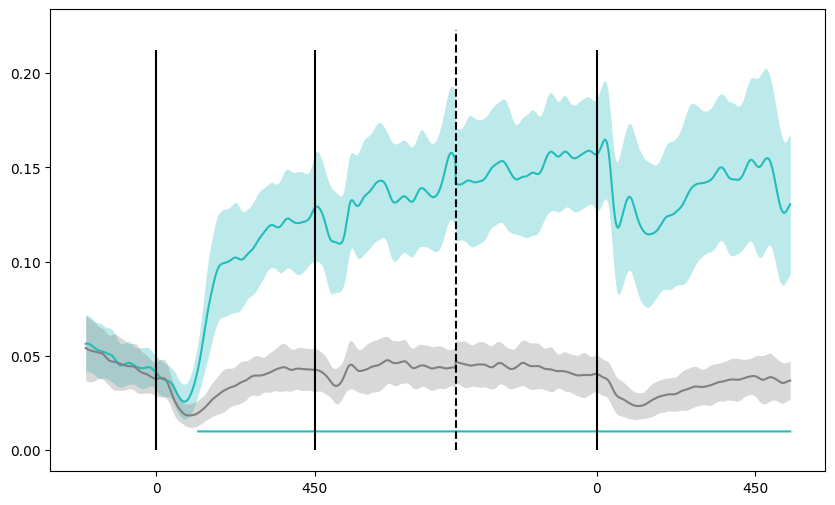

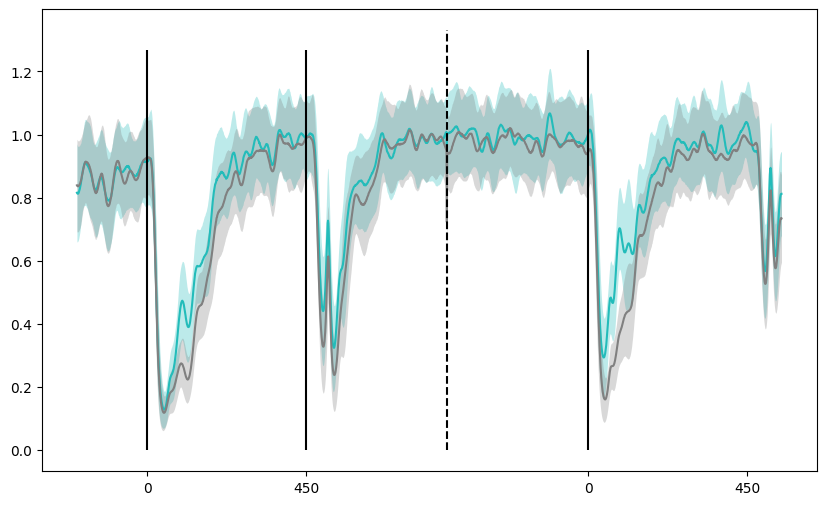

In [175]:
area='lip'
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=res.distance['dist_n_nn']
fd=res.distance['dist_fake_n_nn']

p = perm_test(d,fd)
p = np.where(p>0.95,True,np.nan)
latency,_=smetrics.find_latency(
    p_value=1-p, win=75, step= 1, p_treshold= 0.05
    )   
p[:latency]=np.nan
latency=latency-200

_=plt.plot(np.arange(len(p))-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p))-200,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-200,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p))-200,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p))-200,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0, 450, 1250, 1700])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0, 450, 450 + 400 + 400],0,ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850],0,ax.get_ylim()[1],color="k",linestyles="--")
# -------------------------------
area='lip'
ia=0
fig,ax=plt.subplots(figsize=(10,6))
d=res.distance['distv_n_nn']
fd=res.distance['distv_fake_n_nn']


_=plt.plot(np.arange(len(p)-1)-200,np.mean(d,axis=0),color=color[area],label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(d,axis=0)
plt.fill_between(np.arange(len(p)-1)-200,np.mean(d,axis=0)-yerr,np.mean(d,axis=0)+yerr,color=color[area],alpha=0.3,linewidth=0.0)

_=plt.plot(np.arange(len(p)-1)-200,np.mean(fd,axis=0),color='grey',label=area+'(n:'+str(res.distance['n_neurons'])+') - Lat='+str(latency))
yerr=np.std(fd,axis=0)
plt.fill_between(np.arange(len(p)-1)-200,np.mean(fd,axis=0)-yerr,np.mean(fd,axis=0)+yerr,color='grey',alpha=0.3,linewidth=0.0)

#_=plt.plot(np.arange(len(p))-200,(p/100)-(ia/100),color=color[area])

ax.set_xticks([0, 450, 1250, 1700])
ax.set_xticklabels(["0", "450", "0", "450"])
ax.vlines([0, 450, 450 + 400 + 400],0,ax.get_ylim()[1],color="k",linestyles="-")
ax.vlines([850],0,ax.get_ylim()[1],color="k",linestyles="--")

In [54]:
p

array([nan, nan, nan, ..., nan, nan, nan])

In [160]:
from numpy import arccos, array
from numpy.linalg import norm
import math

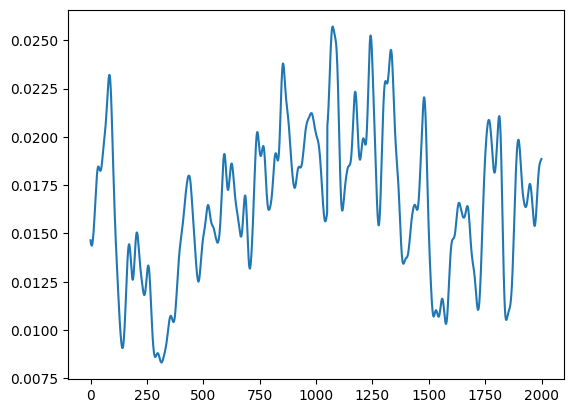

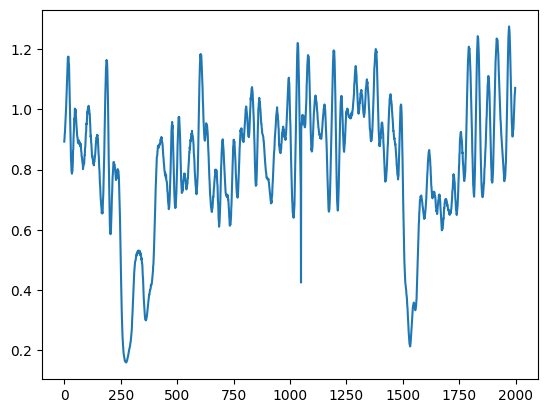

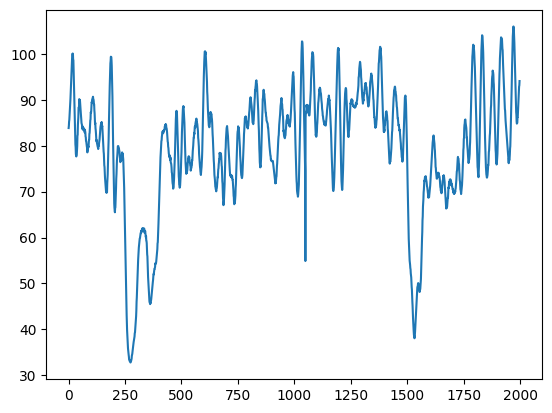

In [166]:
plt.plot(np.array(distpos_n_nn).reshape(-1))
plt.subplots()
plt.plot(np.array(distv_n_nn).reshape(-1))
plt.subplots()
plt.plot(np.array(pp).reshape(-1))

In [228]:
import numpy as np

# Function to generate random samples and compute the average vector
def generate_average_vector(n_samples, dim, distribution=np.random.normal):
    # Generate 'n_samples' vectors of dimension 'dim'
    samples = distribution(size=(n_samples, dim))
    
    return samples

# Function to compute the angle between two vectors
def compute_angle_between_vectors(vec1, vec2):
    # Compute the dot product
    dot_product = np.dot(vec1, vec2)
    # Compute the norms (magnitudes)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    # Compute the cosine of the angle
    cos_theta = dot_product / (norm_vec1 * norm_vec2)
    # Return the angle in radians
    return np.arccos(cos_theta)

# Parameters
n_samples = 1000  # Number of samples for each vector
dim = 100         # Dimension of the vectors

# Generate two average vectors from the same distribution
samples = generate_average_vector(n_samples*2, dim)
vector1 = np.mean(samples[:n_samples], axis=0)
vector2 = np.mean(samples[n_samples:], axis=0)

# Compute the angle between the two vectors
angle = compute_angle_between_vectors(vector1, vector2)

# Convert the angle from radians to degrees
angle_degrees = np.degrees(angle)

print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")

Angle between the two vectors (in radians): 1.6737182755582394
Angle between the two vectors (in degrees): 95.89699328340124


(array([ 2.,  3.,  5., 10., 15., 19., 19., 16.,  8.,  3.]),
 array([-0.08173799, -0.06731004, -0.05288209, -0.03845414, -0.02402619,
        -0.00959824,  0.0048297 ,  0.01925765,  0.0336856 ,  0.04811355,
         0.0625415 ]),
 <BarContainer object of 10 artists>)

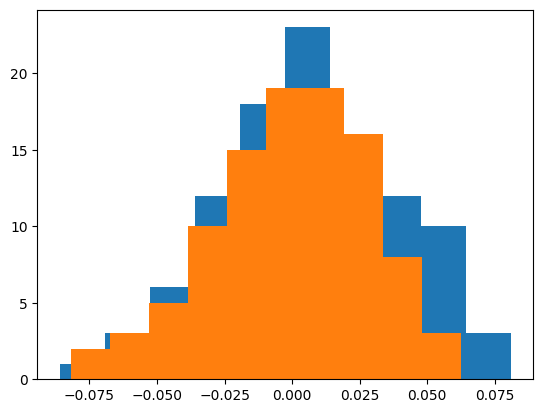

In [229]:
plt.hist(vector1)
plt.hist(vector2)

In [264]:
import numpy as np

# Function to generate random samples from a specified distribution and compute the average vector
def generate_average_vector(n_samples, dim, distribution_func):
    # Generate 'n_samples' vectors of dimension 'dim' from the given distribution function
    samples = distribution_func(size=(n_samples, dim))
    # Compute the average vector
    avg_vector = np.mean(samples, axis=0)
    return avg_vector

# Function to compute the angle between two vectors
def compute_angle_between_vectors(vec1, vec2):
    # Compute the dot product
    dot_product = np.dot(vec1, vec2)
    # Compute the norms (magnitudes)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    # Compute the cosine of the angle
    cos_theta = dot_product / (norm_vec1 * norm_vec2)
    # Return the angle in radians
    return np.arccos(cos_theta)

# Parameters
n_samples = 1000  # Number of samples for each vector
dim = 2         # Dimension of the vectors

# Generate two average vectors, one from each different distribution
# For example, vector1 is from a normal distribution and vector2 from a uniform distribution

# Normal distribution for vector1
vector1 = generate_average_vector(n_samples, dim, np.random.normal)+5

# Uniform distribution for vector2 (between -1 and 1)
vector2 = generate_average_vector(n_samples, dim, np.random.normal)+5#generate_average_vector(n_samples, dim, lambda size: np.random.uniform(-10, 1, size=size))

# Compute the angle between the two vectors
angle = compute_angle_between_vectors(vector1, vector2)

# Convert the angle from radians to degrees
angle_degrees = np.degrees(angle)

print(f"Angle between the two vectors (in radians): {angle}")
print(f"Angle between the two vectors (in degrees): {angle_degrees}")


Angle between the two vectors (in radians): 0.0050363977398801465
Angle between the two vectors (in degrees): 0.288564334444359


(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([5.01194821, 5.01520027, 5.01845233, 5.02170439, 5.02495644,
        5.0282085 , 5.03146056, 5.03471261, 5.03796467, 5.04121673,
        5.04446879]),
 <BarContainer object of 10 artists>)

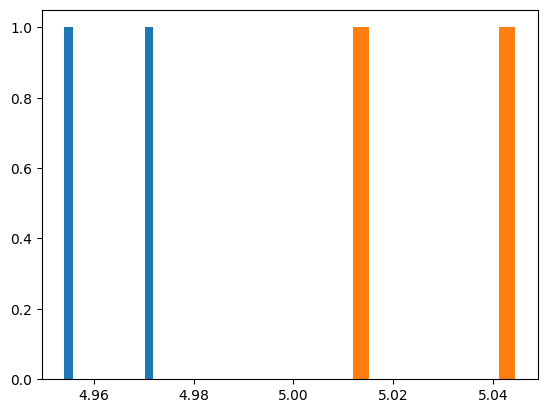

In [265]:
plt.hist(vector1)
plt.hist(vector2)

In [218]:
vector1

array([ 9.99429628,  9.96000826,  9.99579057,  9.9370742 ,  9.97828353,
       10.0134193 ,  9.99377115,  9.97022852,  9.92391577, 10.00048935,
        9.98989938,  9.9939434 , 10.01097628,  9.99699893,  9.98768291,
       10.04704539, 10.05477639, 10.04717641,  9.96673292, 10.03010072,
        9.97441609, 10.02059096,  9.99697385,  9.99019983,  9.99771275,
        9.98665067, 10.0360511 , 10.01793955, 10.00819963, 10.00873662,
       10.01128936, 10.0284571 ,  9.97806618,  9.97335162,  9.96726862,
       10.0718475 ,  9.98903935, 10.00060213,  9.96225959, 10.04243068,
       10.06875525, 10.03910533, 10.0264772 , 10.02442684, 10.01451578,
       10.00458279,  9.97497375,  9.9895241 ,  9.98101317, 10.02591115,
       10.02105208,  9.99552561, 10.06153459,  9.98577307,  9.95554452,
        9.95104008, 10.01764929,  9.97757229, 10.00861721, 10.05889829,
        9.93731808, 10.0283622 ,  9.96875315, 10.00472647, 10.00202208,
        9.99507163, 10.01143911, 10.01296585, 10.00933612,  9.97